In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from PIL import Image
import time  # 导入time模块
import matplotlib.pyplot as plt  # 导入matplotlib模块

In [2]:
# 定义数据集路径
train_label_path = "data_sort/train/label.txt"
test_label_path = "data_sort/test/label.txt"

In [3]:
# 读取标签和数据
labels = {}
train_data = []
test_data = []

In [4]:
with open(train_label_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        k_v = line.split(' ')
        train_data.append(k_v[0])
        labels[k_v[0]] = k_v[1]

class GetTrainLoader(torch.utils.data.Dataset):
    def __init__(self):
        self.data = train_data
        self.label = labels
        self.transform_train = transforms.Compose([
            transforms.Resize((135, 240)),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        im_id = self.data[index]
        image = Image.open(im_id)
        image = image.crop([300, 80, 1620, 950])
        image = self.transform_train(image)
        label = int(self.label[im_id])
        return image, label, im_id

    def __len__(self):
        return len(self.data)

with open(test_label_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        k_v = line.split(' ')
        test_data.append(k_v[0])
        labels[k_v[0]] = k_v[1]

class GetTestLoader(torch.utils.data.Dataset):
    def __init__(self):
        self.data = test_data
        self.label = labels
        self.transform_test = transforms.Compose([
            transforms.Resize((135, 240)),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        im_id = self.data[index]
        image = Image.open(im_id)
        image = image.crop([300, 80, 1620, 950])
        image = self.transform_test(image)
        label = int(self.label[im_id])
        return image, label, im_id

    def __len__(self):
        return len(self.data)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=5):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)      
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)        
        self.fc = nn.Linear(14336, num_classes)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # 展平成一维
        #print(out.shape)  # 调试信息，打印输出尺寸
        out = self.fc(out)
        return out
    
def ResNet18():
    return ResNet(ResidualBlock)

In [6]:
#检查GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# 设置超参数
EPOCH = 25
pre_epoch = 0
BATCH_SIZE = 8
LR = 0.0004

In [8]:
# 准备数据集
train_labeled_set = GetTrainLoader()  # label
trainloader = DataLoader(train_labeled_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

test_labeled_set = GetTestLoader()  # label
testloader = DataLoader(test_labeled_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

In [9]:
# 定义 ResNet18
net = ResNet18().to(device)

In [10]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.8, weight_decay=5e-4)

In [11]:
# 创建 GradScaler 实例
scaler = GradScaler()

In [12]:
# 记录每个epoch的训练损失、训练准确率和测试准确率
train_losses = []
train_accuracies = []
test_accuracies = []

# 训练过程
total_start_time = time.time()  # 记录开始时间
for epoch in range(pre_epoch, EPOCH):

    print('\nEpoch: %d' % (epoch + 1))
    epoch_start_time = time.time()  # 记录每个epoch的开始时间
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    # 使用tqdm显示训练进度
    with tqdm(total=len(trainloader), desc=f'Epoch {epoch + 1}/{EPOCH}', unit='batch') as pbar:
        for i, data in enumerate(trainloader, 0):
            # 准备数据集
            inputs, labels, im_idx = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # 使用autocast进行前向传播
            with autocast():
                outputs = net(inputs)
                loss = criterion(outputs, labels)

            # 使用scaler进行反向传播
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # 计算损失和准确率
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()

            # 更新进度条
            pbar.set_postfix(loss=sum_loss / (i + 1), accuracy=100. * correct / total)
            pbar.update(1)

    epoch_end_time = time.time()  # 记录每个epoch的结束时间
    epoch_duration = epoch_end_time - epoch_start_time  # 计算每个epoch的持续时间
    epoch_accuracy = 100. * correct / total  # 计算训练准确度

    # 记录训练损失和准确率
    train_losses.append(sum_loss / len(trainloader))
    train_accuracies.append(epoch_accuracy.cpu().numpy())

    print(
        f'Epoch [{epoch + 1}/{EPOCH}], Loss: {sum_loss / len(trainloader):.4f}, Accuracy: {epoch_accuracy:.2f}%, Duration: {epoch_duration:.2f}s')

    # 测试集上的准确率
    print('Waiting Test...')
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            inputs, labels, _ = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        test_accuracy = 100. * correct.float() / total
        test_accuracies.append(test_accuracy.cpu().numpy())
        print('Test\'s accuracy is: %.3f%%' % test_accuracy)

    # 每个 epoch 结束后清理缓存
    torch.cuda.empty_cache()

total_end_time = time.time()  # 记录总训练时间的结束时间
total_duration = total_end_time - total_start_time  # 计算总训练时间

print(f'Total Training Time: {total_duration:.2f}s')


Epoch: 1


Epoch 1/25: 100%|██████████| 30/30 [00:01<00:00, 15.21batch/s, accuracy=tensor(60.8333), loss=1.09]

Epoch [1/25], Loss: 1.0874, Accuracy: 60.83%, Duration: 1.98s
Waiting Test...



/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test's accuracy is: 15.519%

Epoch: 2


Epoch 2/25: 100%|██████████| 30/30 [00:01<00:00, 20.69batch/s, accuracy=tensor(80.4167), loss=0.454]

Epoch [2/25], Loss: 0.4544, Accuracy: 80.42%, Duration: 1.45s
Waiting Test...


Test's accuracy is: 49.332%

Epoch: 3


Epoch 3/25: 100%|██████████| 30/30 [00:01<00:00, 20.67batch/s, accuracy=tensor(95.), loss=0.135]    

Epoch [3/25], Loss: 0.1353, Accuracy: 95.00%, Duration: 1.45s
Waiting Test...


Test's accuracy is: 93.628%

Epoch: 4


Epoch 4/25: 100%|██████████| 30/30 [00:01<00:00, 21.50batch/s, accuracy=tensor(99.1667), loss=0.0431]

Epoch [4/25], Loss: 0.0431, Accuracy: 99.17%, Duration: 1.40s
Waiting Test...


Test's accuracy is: 93.011%

Epoch: 5


Epoch 5/25: 100%|██████████| 30/30 [00:01<00:00, 21.49batch/s, accuracy=tensor(100.), loss=0.0205]

Epoch [5/25], Loss: 0.0205, Accuracy: 100.00%, Duration: 1.40s
Waiting Test...


Test's accuracy is: 93.217%

Epoch: 6


Epoch 6/25: 100%|██████████| 30/30 [00:01<00:00, 20.72batch/s, accuracy=tensor(98.3333), loss=0.0572]

Epoch [6/25], Loss: 0.0572, Accuracy: 98.33%, Duration: 1.45s
Waiting Test...


Test's accuracy is: 77.184%

Epoch: 7


Epoch 7/25: 100%|██████████| 30/30 [00:01<00:00, 22.05batch/s, accuracy=tensor(99.5833), loss=0.0185]

Epoch [7/25], Loss: 0.0185, Accuracy: 99.58%, Duration: 1.36s
Waiting Test...


Test's accuracy is: 94.347%

Epoch: 8


Epoch 8/25: 100%|██████████| 30/30 [00:01<00:00, 21.86batch/s, accuracy=tensor(99.5833), loss=0.0181]

Epoch [8/25], Loss: 0.0181, Accuracy: 99.58%, Duration: 1.37s
Waiting Test...


Test's accuracy is: 93.936%

Epoch: 9


Epoch 9/25: 100%|██████████| 30/30 [00:01<00:00, 22.24batch/s, accuracy=tensor(100.), loss=0.00941]

Epoch [9/25], Loss: 0.0094, Accuracy: 100.00%, Duration: 1.35s
Waiting Test...


Test's accuracy is: 95.170%

Epoch: 10


Epoch 10/25: 100%|██████████| 30/30 [00:01<00:00, 22.10batch/s, accuracy=tensor(100.), loss=0.00582]

Epoch [10/25], Loss: 0.0058, Accuracy: 100.00%, Duration: 1.36s
Waiting Test...


Test's accuracy is: 94.656%

Epoch: 11


Epoch 11/25: 100%|██████████| 30/30 [00:01<00:00, 21.38batch/s, accuracy=tensor(100.), loss=0.00536]

Epoch [11/25], Loss: 0.0054, Accuracy: 100.00%, Duration: 1.41s
Waiting Test...


Test's accuracy is: 94.347%

Epoch: 12


Epoch 12/25: 100%|██████████| 30/30 [00:01<00:00, 22.05batch/s, accuracy=tensor(100.), loss=0.00463]

Epoch [12/25], Loss: 0.0046, Accuracy: 100.00%, Duration: 1.36s
Waiting Test...


Test's accuracy is: 95.170%

Epoch: 13


Epoch 13/25: 100%|██████████| 30/30 [00:01<00:00, 21.84batch/s, accuracy=tensor(100.), loss=0.00537]

Epoch [13/25], Loss: 0.0054, Accuracy: 100.00%, Duration: 1.38s
Waiting Test...


Test's accuracy is: 93.628%

Epoch: 14


Epoch 14/25: 100%|██████████| 30/30 [00:01<00:00, 22.17batch/s, accuracy=tensor(100.), loss=0.0052] 

Epoch [14/25], Loss: 0.0052, Accuracy: 100.00%, Duration: 1.36s
Waiting Test...


Test's accuracy is: 94.245%

Epoch: 15


Epoch 15/25: 100%|██████████| 30/30 [00:01<00:00, 22.17batch/s, accuracy=tensor(100.), loss=0.00401]

Epoch [15/25], Loss: 0.0040, Accuracy: 100.00%, Duration: 1.36s
Waiting Test...


Test's accuracy is: 95.067%

Epoch: 16


Epoch 16/25: 100%|██████████| 30/30 [00:01<00:00, 22.02batch/s, accuracy=tensor(99.5833), loss=0.019] 

Epoch [16/25], Loss: 0.0190, Accuracy: 99.58%, Duration: 1.37s
Waiting Test...


Test's accuracy is: 94.450%

Epoch: 17


Epoch 17/25: 100%|██████████| 30/30 [00:01<00:00, 21.96batch/s, accuracy=tensor(100.), loss=0.00451]


Epoch [17/25], Loss: 0.0045, Accuracy: 100.00%, Duration: 1.37s
Waiting Test...
Test's accuracy is: 94.861%

Epoch: 18


Epoch 18/25: 100%|██████████| 30/30 [00:01<00:00, 22.17batch/s, accuracy=tensor(100.), loss=0.00283]

Epoch [18/25], Loss: 0.0028, Accuracy: 100.00%, Duration: 1.36s
Waiting Test...


Test's accuracy is: 94.450%

Epoch: 19


Epoch 19/25: 100%|██████████| 30/30 [00:01<00:00, 22.18batch/s, accuracy=tensor(100.), loss=0.00271]


Epoch [19/25], Loss: 0.0027, Accuracy: 100.00%, Duration: 1.36s
Waiting Test...
Test's accuracy is: 95.375%

Epoch: 20


Epoch 20/25: 100%|██████████| 30/30 [00:01<00:00, 21.88batch/s, accuracy=tensor(100.), loss=0.00315]

Epoch [20/25], Loss: 0.0032, Accuracy: 100.00%, Duration: 1.37s
Waiting Test...


Test's accuracy is: 95.170%

Epoch: 21


Epoch 21/25: 100%|██████████| 30/30 [00:01<00:00, 21.91batch/s, accuracy=tensor(100.), loss=0.00279]

Epoch [21/25], Loss: 0.0028, Accuracy: 100.00%, Duration: 1.37s
Waiting Test...


Test's accuracy is: 95.478%

Epoch: 22


Epoch 22/25: 100%|██████████| 30/30 [00:01<00:00, 22.04batch/s, accuracy=tensor(100.), loss=0.00229]

Epoch [22/25], Loss: 0.0023, Accuracy: 100.00%, Duration: 1.36s
Waiting Test...


Test's accuracy is: 95.375%

Epoch: 23


Epoch 23/25: 100%|██████████| 30/30 [00:01<00:00, 21.14batch/s, accuracy=tensor(100.), loss=0.00255]

Epoch [23/25], Loss: 0.0026, Accuracy: 100.00%, Duration: 1.42s
Waiting Test...


Test's accuracy is: 94.758%

Epoch: 24


Epoch 24/25: 100%|██████████| 30/30 [00:01<00:00, 19.21batch/s, accuracy=tensor(100.), loss=0.00208]

Epoch [24/25], Loss: 0.0021, Accuracy: 100.00%, Duration: 1.56s
Waiting Test...


Test's accuracy is: 95.478%

Epoch: 25


Epoch 25/25: 100%|██████████| 30/30 [00:01<00:00, 21.82batch/s, accuracy=tensor(100.), loss=0.00184]


Epoch [25/25], Loss: 0.0018, Accuracy: 100.00%, Duration: 1.38s
Waiting Test...
Test's accuracy is: 95.272%
Total Training Time: 97.96s


In [13]:
# 训练结束后保存模型权重
model_path = './resnet18_weights_v1.pth'
torch.save(net.state_dict(), model_path)
print(f'Model weights saved to {model_path}')

print('Train has finished, total epoch is %d' % EPOCH)

Model weights saved to ./resnet18_weights_v1.pth
Train has finished, total epoch is 25


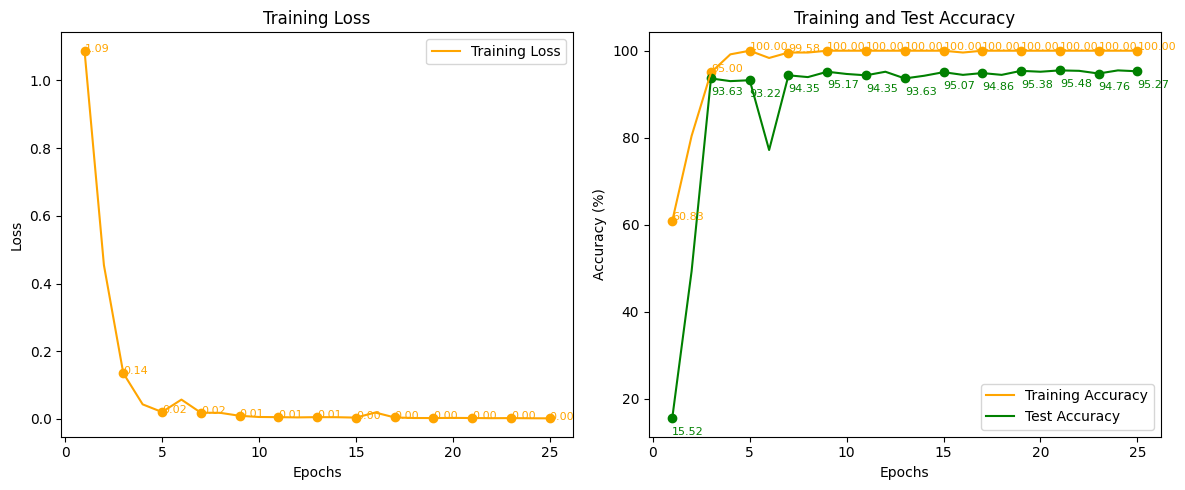

In [14]:
# 绘制训练损失和准确率变化曲线
epochs = range(1, EPOCH + 1)
plt.figure(figsize=(12, 5))

# 训练损失曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'orange', label='Training Loss')
# 每五个epoch标记一个点并显示数值
for i in range(0, EPOCH, 2):
    plt.scatter(epochs[i], train_losses[i], color='orange')
    plt.text(epochs[i], train_losses[i] + 0.02, f'{train_losses[i]:.2f}', ha='left', va='top', color='orange', fontsize=8)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss1.png')  # 保存训练损失图像

# 训练和测试准确率曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'orange', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'green', label='Test Accuracy')
# 每五个epoch标记一个点并显示数值
for i in range(0, EPOCH, 2):
    plt.scatter(epochs[i], train_accuracies[i], color='orange')
    plt.text(epochs[i], train_accuracies[i] + 2, f'{train_accuracies[i]:.2f}', ha='left', va='top', color='orange', fontsize=8)
    plt.scatter(epochs[i], test_accuracies[i], color='green')
    plt.text(epochs[i], test_accuracies[i] - 2, f'{test_accuracies[i]:.2f}', ha='left', va='top', color='green', fontsize=8)
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('training_and_test_accuracy1.png')  # 保存训练和测试准确率图像

plt.tight_layout()
plt.show()

In [15]:
# 最终测试并保存结果
net.eval()
with torch.no_grad():
    with open("test.txt", 'w') as f:
        for idx, (inputs, targets, im_ids) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, pred = outputs.topk(1, 1, True, True)
            pred = pred.t()
            pred = pred.cpu().numpy().tolist()
            for i in range(inputs.shape[0]):
                f.write(im_ids[i] + ' ' + str(pred[0][i]) + '\n')
    f.close()